<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/Graphs_intial%2Banalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // 100
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    adj_matrix[new_source, new_target] = length
    adj_matrix[new_target, new_source] = length

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    csv_path = os.path.join(folder_path, 'links.csv')
    csv_path_demands = os.path.join(folder_path, 'demands.csv')
    csv_tables.append(folder_name)

    (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands)
    Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь
Graphs = get_graphs(path_to_folder)

In [ ]:
Graphs['cola_test60'] # Выводим пример

{'adj_matrix': array([[ 0.,  0., 60., 60., 60.],
        [ 0.,  0., 60., 60., 60.],
        [60., 60.,  0., 60.,  0.],
        [60., 60., 60.,  0., 60.],
        [60., 60.,  0., 60.,  0.]]),
 'traffic_matrix': array([[ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]]),
 'nodes_params': {'degrees': [np.float64(3.0),
   np.float64(3.0),
   np.float64(3.0),
   np.float64(4.0),
   np.float64(3.0)],
  'source_demands': [np.float64(20.0),
   np.float64(0.0),
   np.float64(20.0),
   np.float64(0.0),
   np.float64(20.0)],
  'target_demands': [np.float64(20.0),
   np.float64(40.0),
   np.float64(0.0),
   np.float64(0.0),
   np.float64(0.0)],
  'sum_demands': [np.float64(20.0),
   np.float64(20.0),
   np.float64(10.0),
   np.float64(0.0),
   np.float64(10.0)]}}

In [ ]:
import networkx as nx
from networkx import *

def graph_topology(main_graph): # Для графа исходного считаем кол-во компонент связности, а после все для наибольшей компоненты
  topology = []

  number_of_connected_components = nx.number_connected_components(main_graph)

  if nx.is_connected(main_graph):
    graph = main_graph
  else:
    components = list(nx.connected_components(main_graph))
    largest_component = max(components, key=len)
    graph = main_graph.subgraph(largest_component)

  num_nodes = graph.number_of_nodes()
  topology.append(num_nodes)

  num_edges = graph.number_of_edges()
  topology.append(num_edges)

  topology.append(number_of_connected_components)

  degrees = graph.degree()
  avg_degree = np.mean(graph.degree(), axis = 0)[1]
  topology.append(avg_degree)

  diameter = nx.diameter(graph)
  topology.append(diameter)

  avg_shortest_path_length = nx.average_shortest_path_length(graph)
  topology.append(avg_shortest_path_length)

  avg_clustering_coefficient = nx.average_clustering(graph)
  topology.append(avg_clustering_coefficient)

  local_clustering = list(nx.clustering(graph).values())
  std_clustering_coefficient = np.std(local_clustering)
  topology.append(std_clustering_coefficient)

  node_betweenness = list(nx.betweenness_centrality(graph).values())
  min_node_betweenness = min(node_betweenness)
  topology.append(min_node_betweenness)
  max_node_betweenness = max(node_betweenness)
  topology.append(max_node_betweenness)
  avg_node_betweenness = sum(node_betweenness) / num_nodes
  topology.append(avg_node_betweenness)

  edge_betweenness = list(nx.edge_betweenness_centrality(graph).values())
  min_edge_betweenness = min(edge_betweenness)
  topology.append(min_edge_betweenness)
  max_edge_betweenness = max(edge_betweenness)
  topology.append(max_edge_betweenness)
  avg_edge_betweenness = sum(edge_betweenness) / num_edges
  topology.append(avg_edge_betweenness)

  L_abs = nx.laplacian_matrix(graph, weight=None)
  L_abs_dense = L_abs.toarray()
  abs_eigenvalues = np.sort(np.linalg.eigvalsh(L_abs_dense))
  absolute_spectral_radius = np.max(abs_eigenvalues)
  topology.append(absolute_spectral_radius)
  absolute_algebraic_connectivity = abs_eigenvalues[1]
  topology.append(absolute_algebraic_connectivity)

  L_norm = nx.normalized_laplacian_matrix(graph, weight=None)
  L_norm_dense = L_norm.toarray()
  norm_eigenvalues = np.sort(np.linalg.eigvalsh(L_norm_dense))
  normalized_spectral_radius = np.max(norm_eigenvalues)
  topology.append(normalized_spectral_radius)
  normalized_algebraic_connectivity = norm_eigenvalues[1]
  topology.append(normalized_algebraic_connectivity)

  return topology

def statistic_dataframe(Graphs): # Делаем сводную таблицу топологий графов
  Topologies = []
  for graph_name, graph_info in Graphs.items():
    adj_matrix = graph_info['adj_matrix']
    graph = nx.from_numpy_array(adj_matrix)
    Topologies.append(graph_topology(graph))

  Topology_labels = ['Number of Nodes', 'Number of Edges', 'Number of Connected Components',
            'Average Node Degree', 'Diameter(hops)', 'Average Shortest Path Length (Hops)', 'Average Clustering Coefficient', 'Standard Deviation of Clustering Coefficient',
            'Minimum Node Betweenness Centrality', 'Maximum Node Betweenness Centrality', 'Average Node Betweenness Centrality',
            'Minimum Edge Betweenness Centrality', 'Maximum Edge Betweenness Centrality', 'Average Edge Betweenness Centrality',
            'Absolute Spectral Radius', 'Absolute Algebraic Connectivity', 'Normalized Spectral Radius', 'Normalized Algebraic Connectivity']

  Table = pd.DataFrame(Topologies, index = Graphs.keys(), columns = Topology_labels)
  Table = Table.sort_index(key=lambda idx: pd.MultiIndex.from_tuples([(s[:4], s[5:]) for s in idx]))

  return Table

Topology_table = statistic_dataframe(Graphs) # Тут используем уже словарь графов

In [ ]:
Topology_table # Смотрим сводную таблицу

Number of Nodes  Number of Edges  \
2024_north                        73              129   
2024_south                        73              126   
2024_southwest                    50               82   
cola_large                      1287             1655   
cola_t1                          667              820   
cola_t10                          83               98   
cola_t2                           32               47   
cola_t3                           21               33   
cola_t5                          405              559   
cola_t6                          405              559   
cola_t7                          162              191   
cola_t8                           54               63   
cola_test60                        5                8   
v806e1152r2110d3183              806              994   
v811e1166r2071d3183              809             1024   

                     Number of Connected Components  Average Node Degree  \
2024_north                                        1             3.534247   
2024_south                                        1             3.452055   
2024_southwest                                    1             3.280000   
cola_large                                        7             2.571873   
cola_t1                                           2             2.458771   
cola_t10                                          1             2.361446   
cola_t2                                           3             2.937500   
cola_t3                                           1             3.142857   
cola_t5                                           4             2.760494   
cola_t6                                           4             2.760494   
cola_t7                                           1             2.358025   
cola_t8                                           1             2.333333   
cola_test60                                       1             3.200000   
v806e1152r2110d3183                               1             2.466501   
v811e1166r2071d3183                               2             2.531520   

                     Diameter(hops)  Average Shortest Path Length (Hops)  \
2024_north                       12                             4.932648   
2024_south                       11                             5.126332   
2024_southwest                   10                             4.435918   
cola_large                       43                            16.686631   
cola_t1                          41                            15.657122   
cola_t10                         16                             7.533059   
cola_t2                           7                             3.266129   
cola_t3                           6                             2.738095   
cola_t5                          41                            15.477729   
cola_t6                          41                            15.477729   
cola_t7                          23                            10.138793   
cola_t8                          16                             6.767296   
cola_test60                       2                             1.200000   
v806e1152r2110d3183              40                            16.375769   
v811e1166r2071d3183              34                            14.603994   

                     Average Clustering Coefficient  \
2024_north                                 0.237900   
2024_south                                 0.224658   
2024_southwest                             0.149143   
cola_large                                 0.053009   
cola_t1                                    0.012627   
cola_t10                                   0.000000   
cola_t2                                    0.075000   
cola_t3                                    0.092063   
cola_t5                                    0.080329   
cola_t6                                    0.080329   
cola_t7                                    0.001940   
cola_t8       

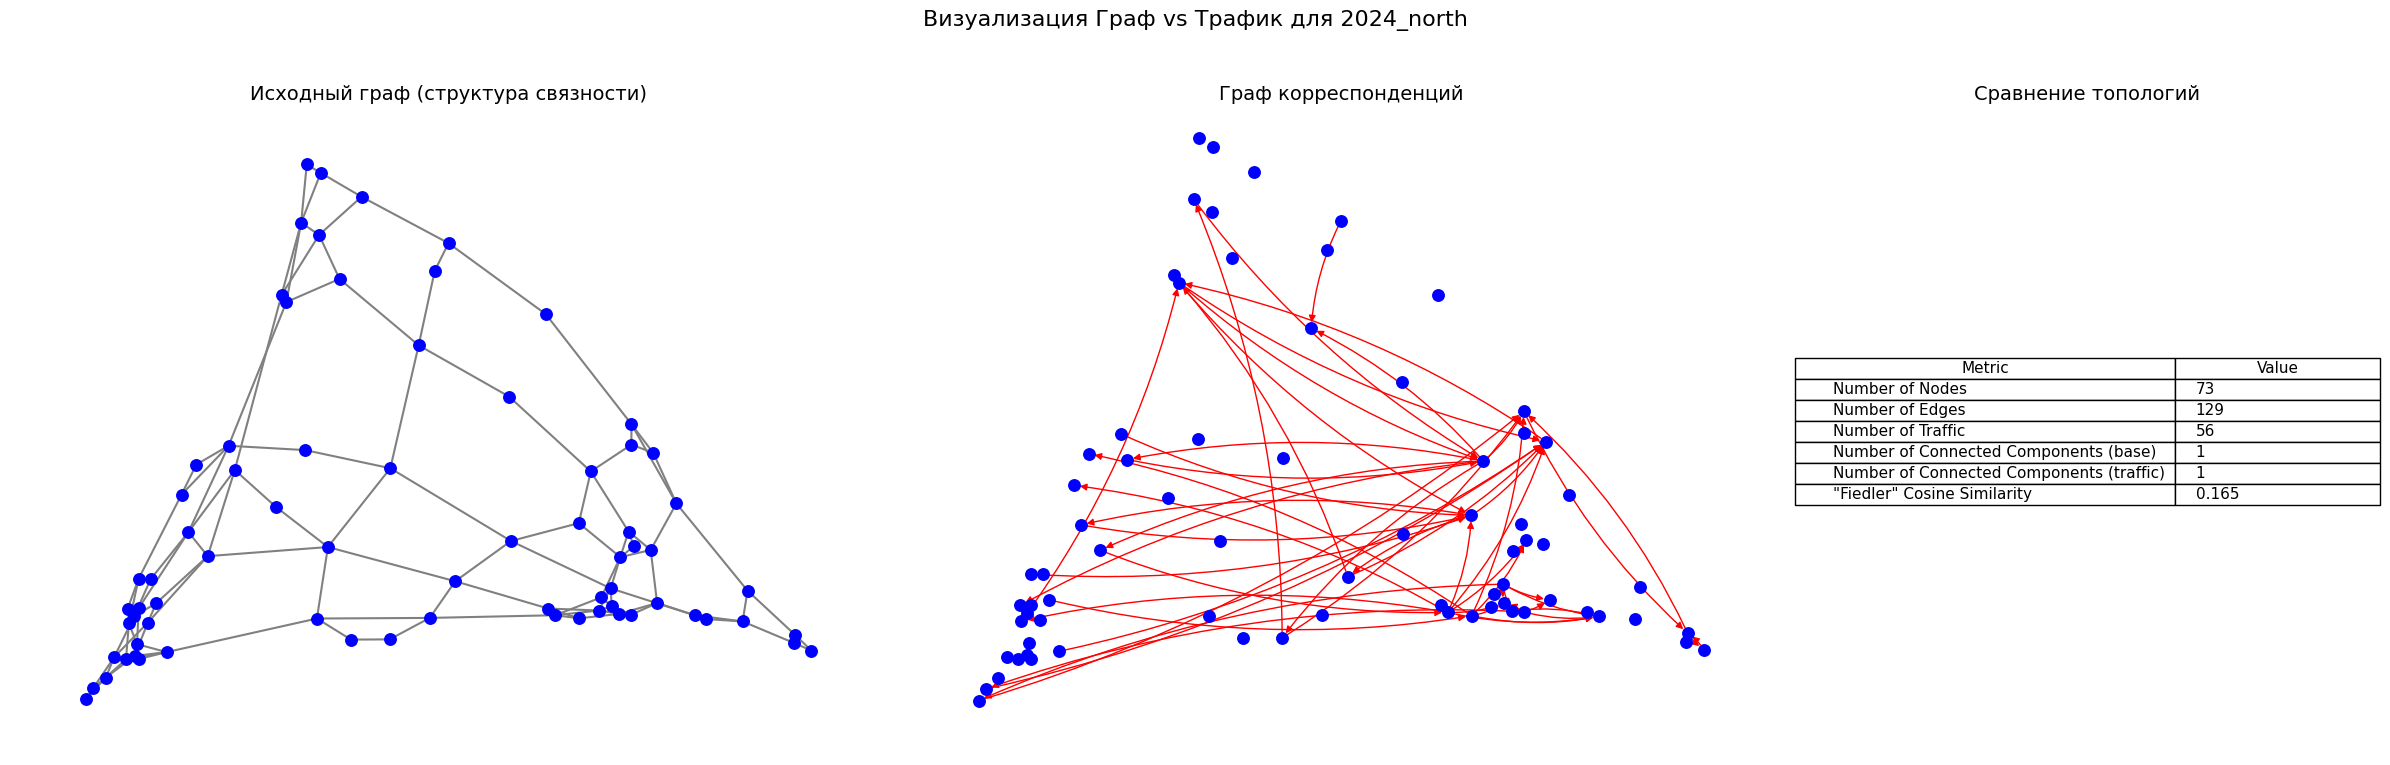

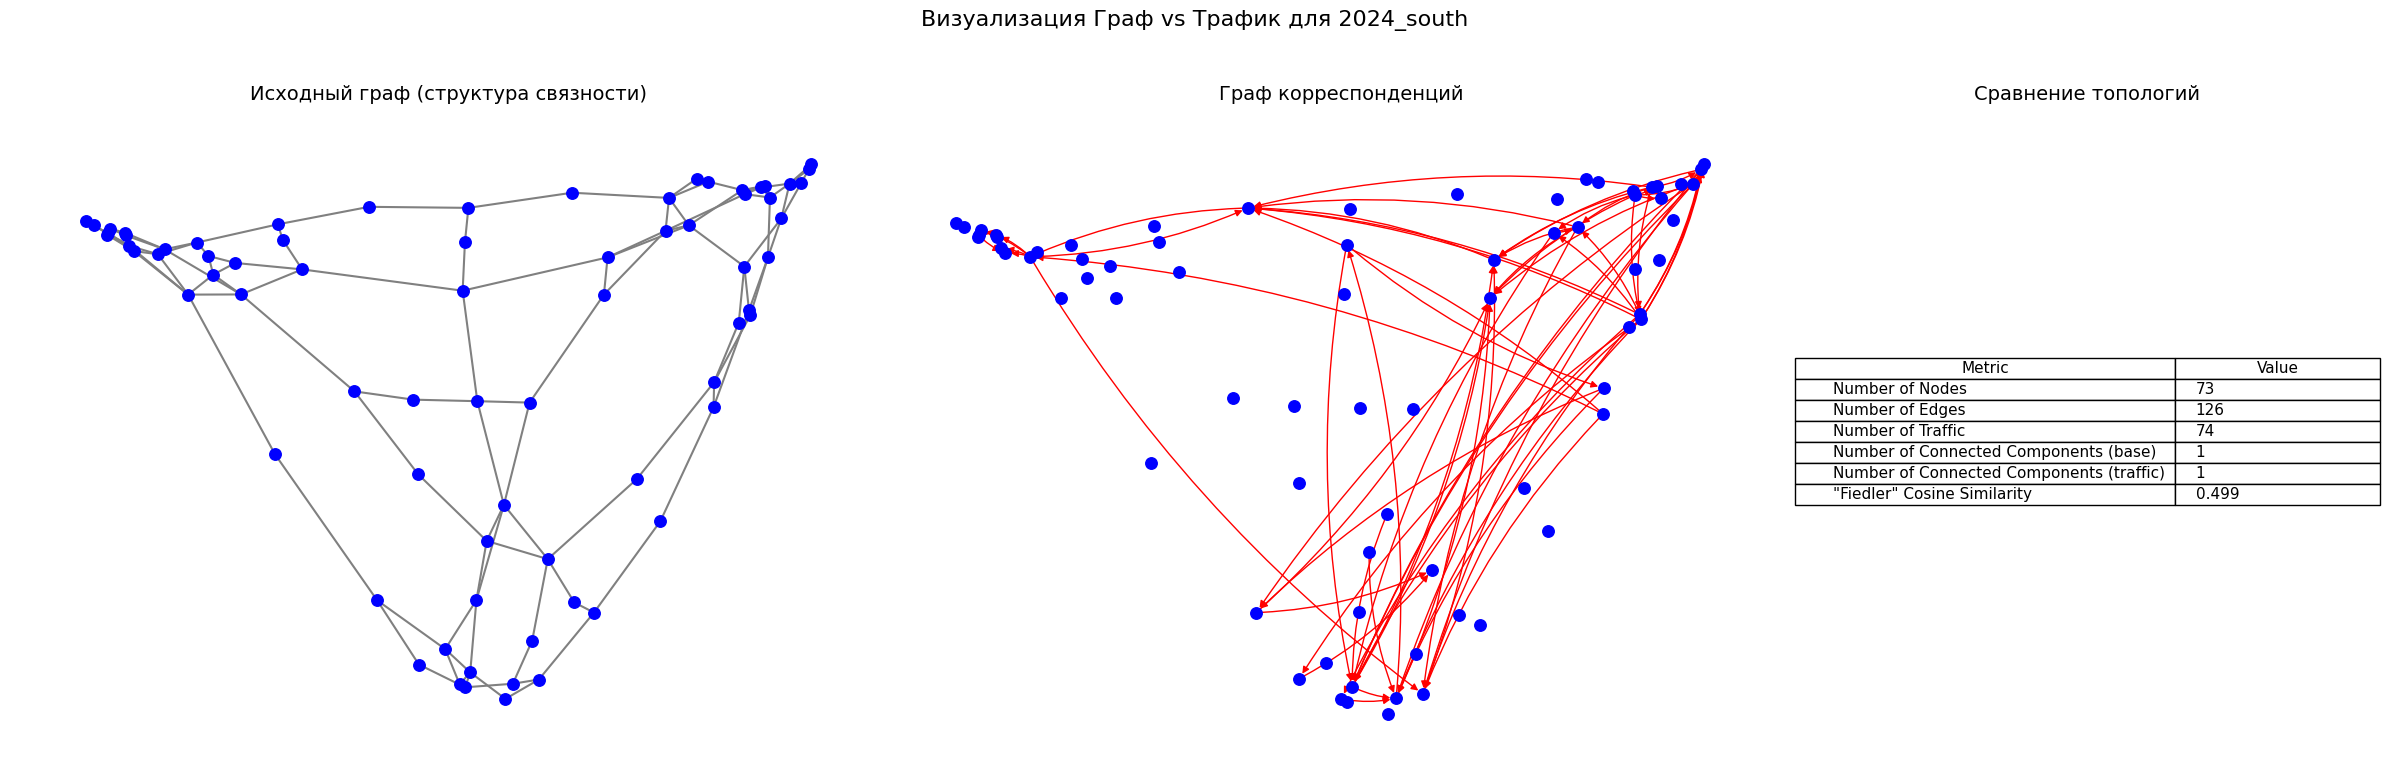

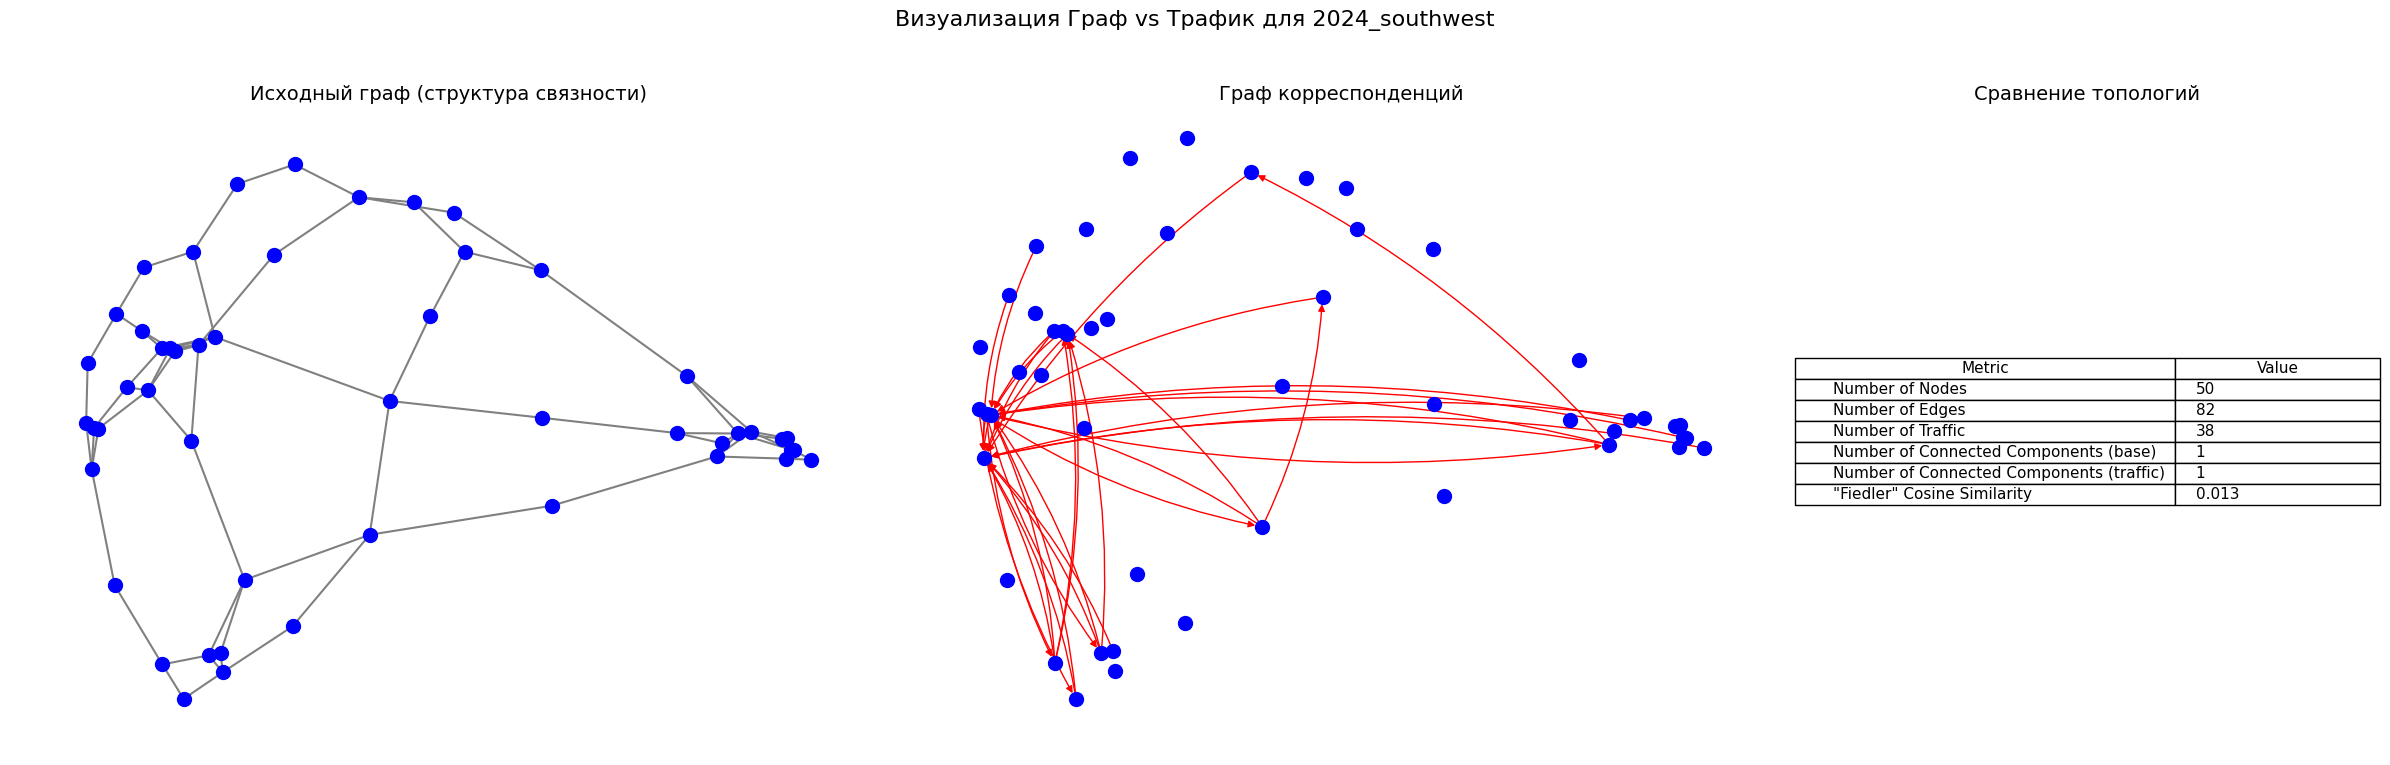

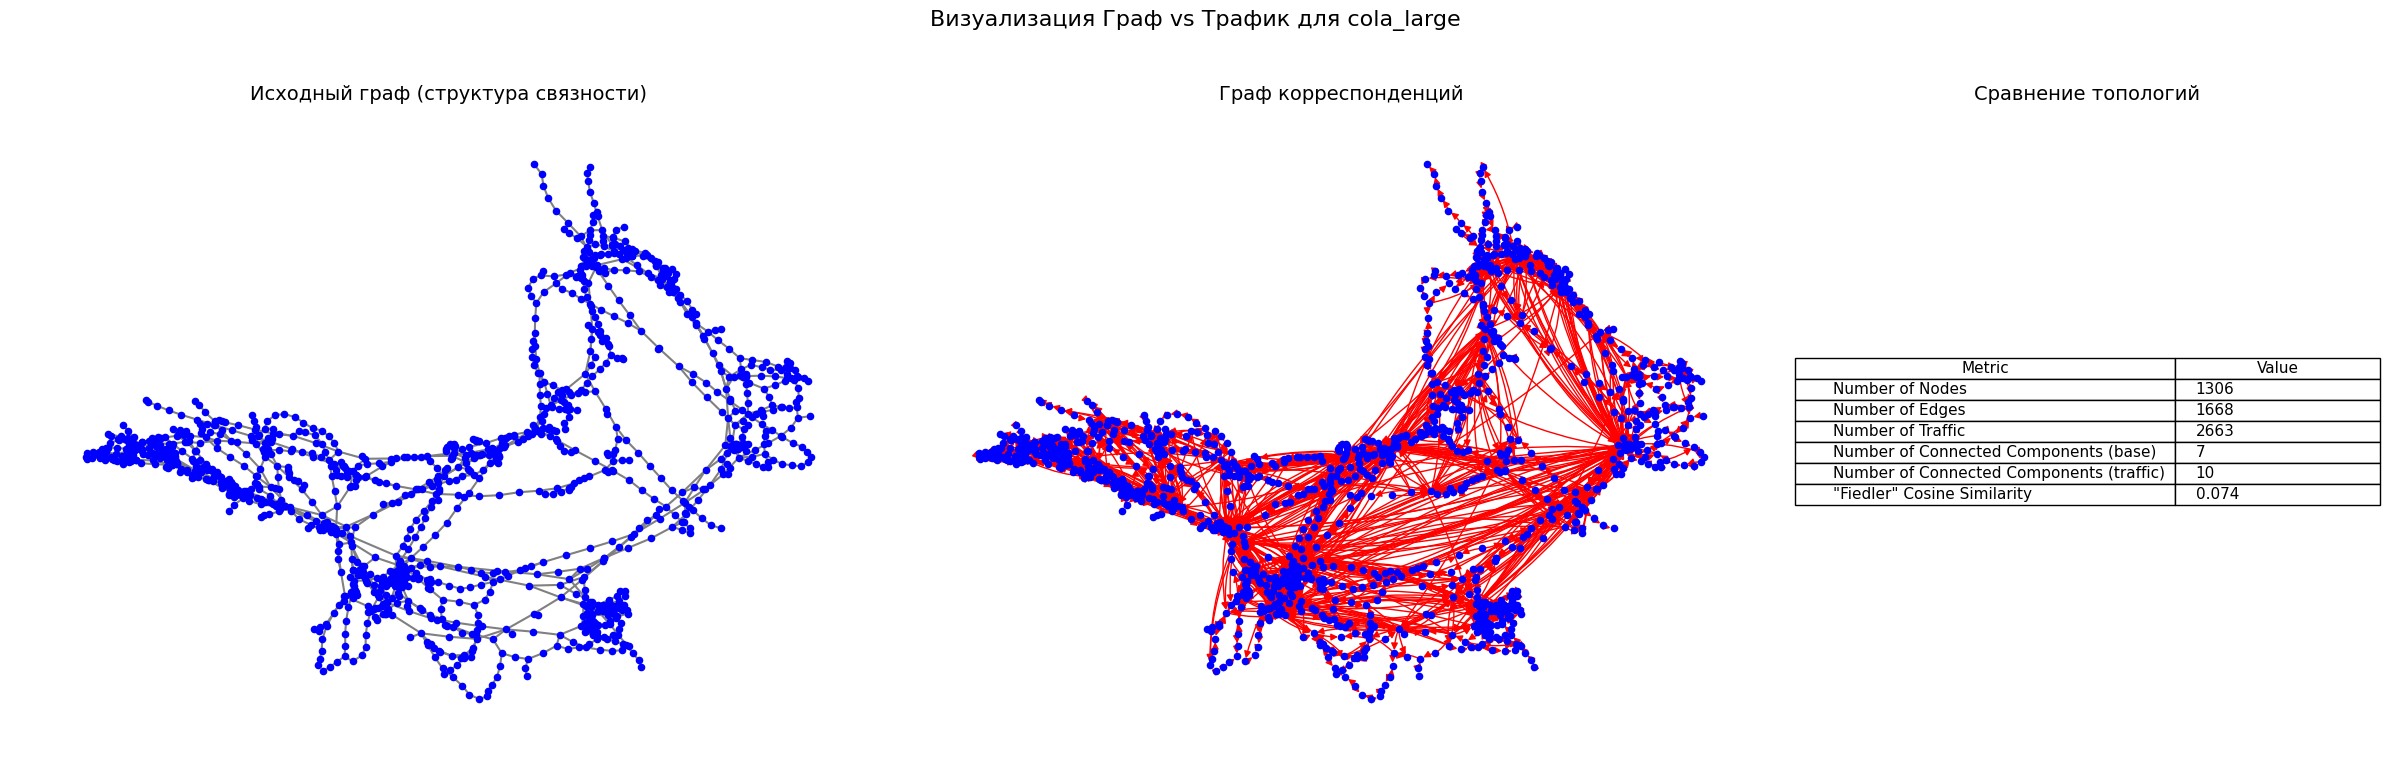

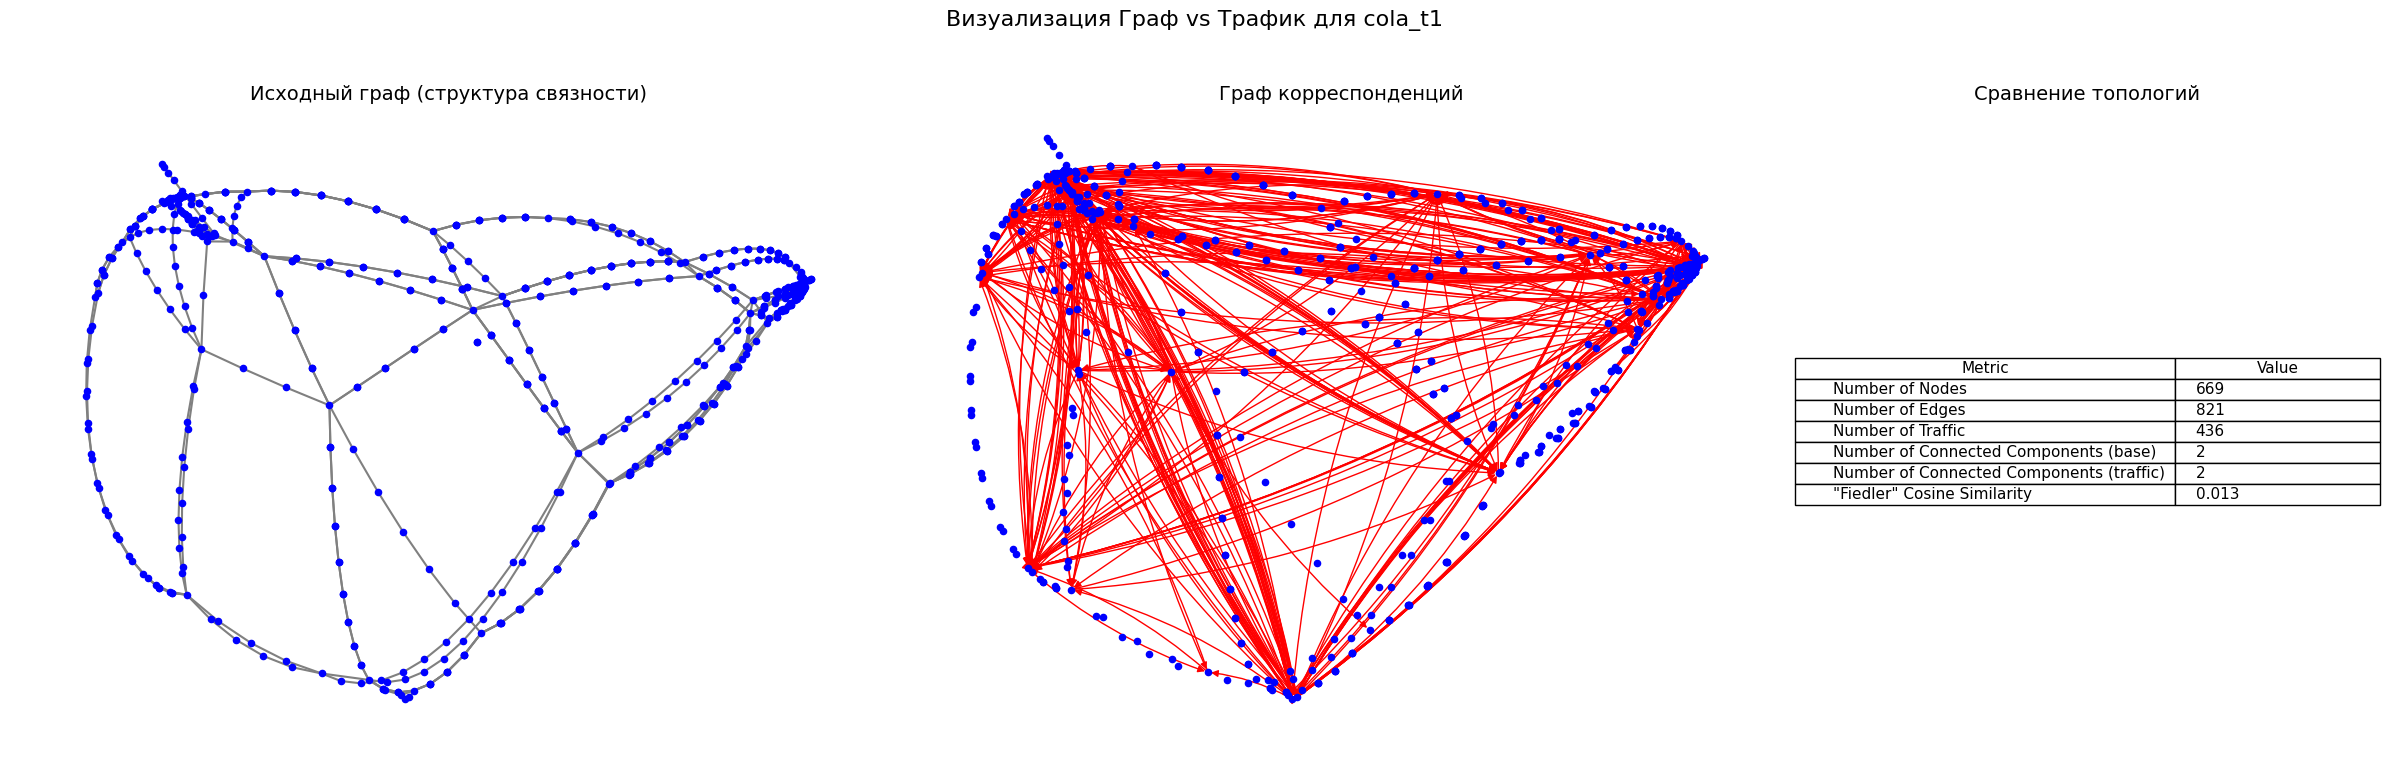

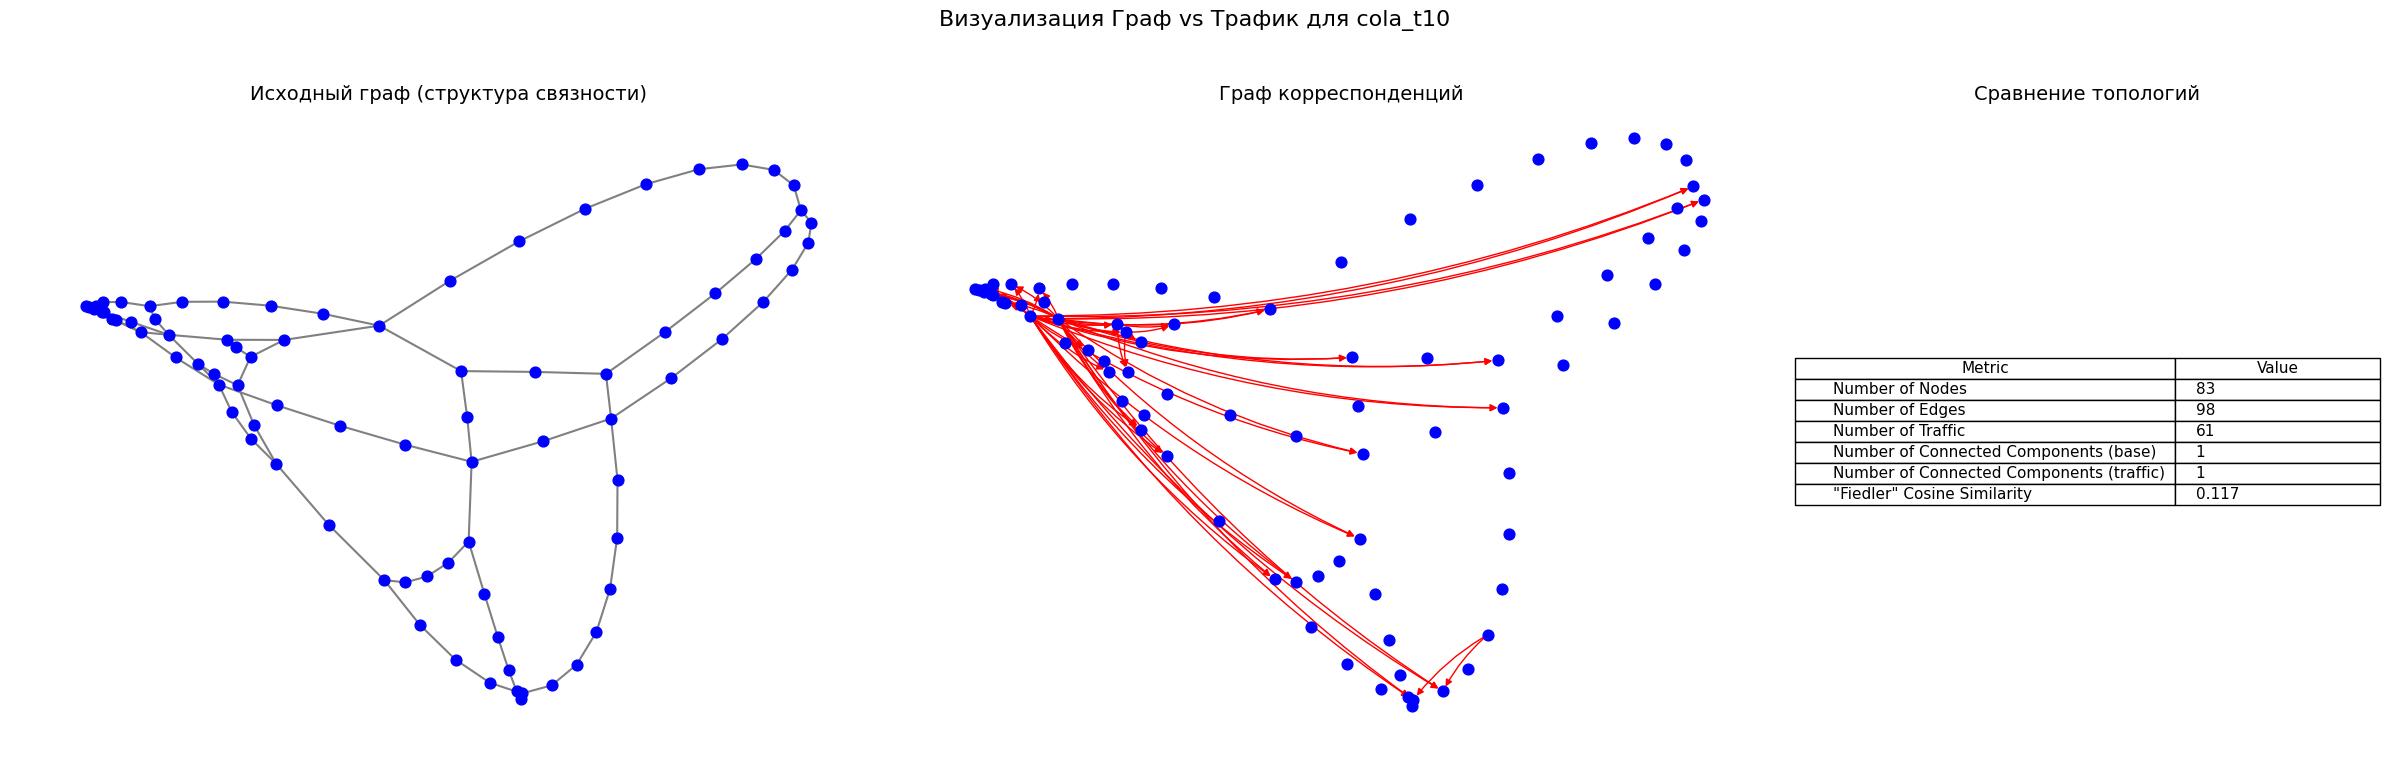

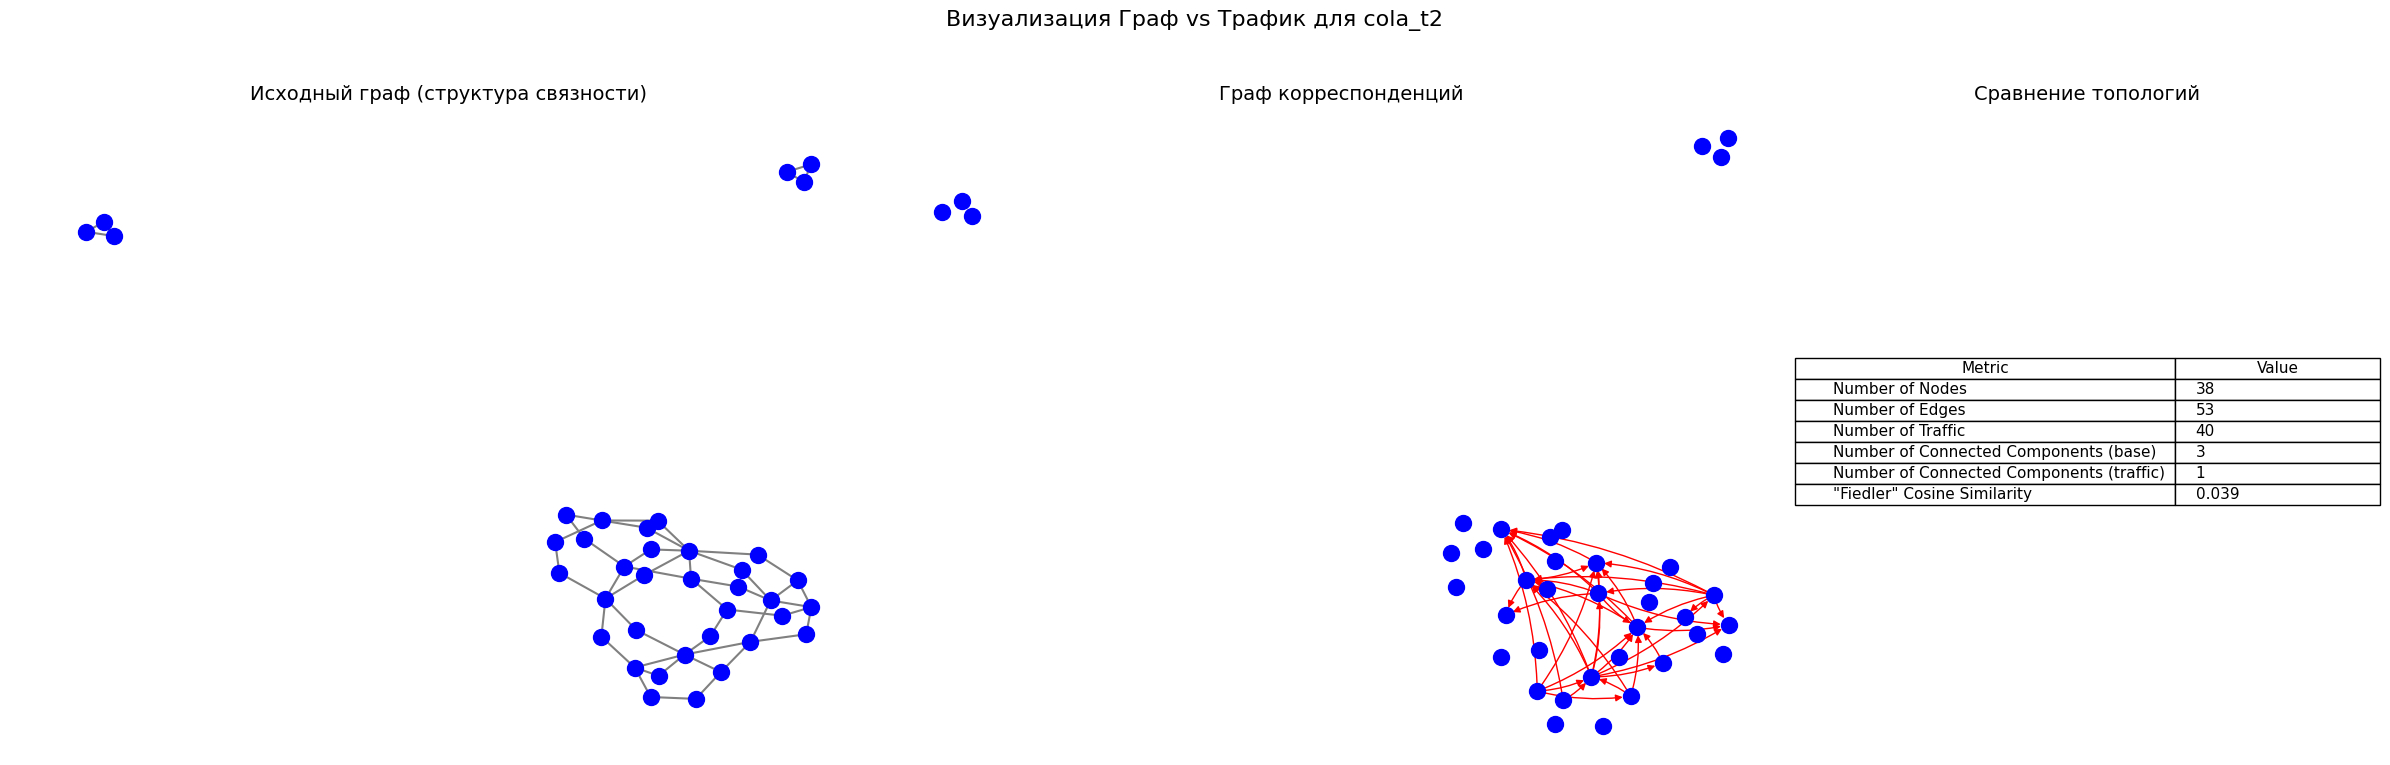

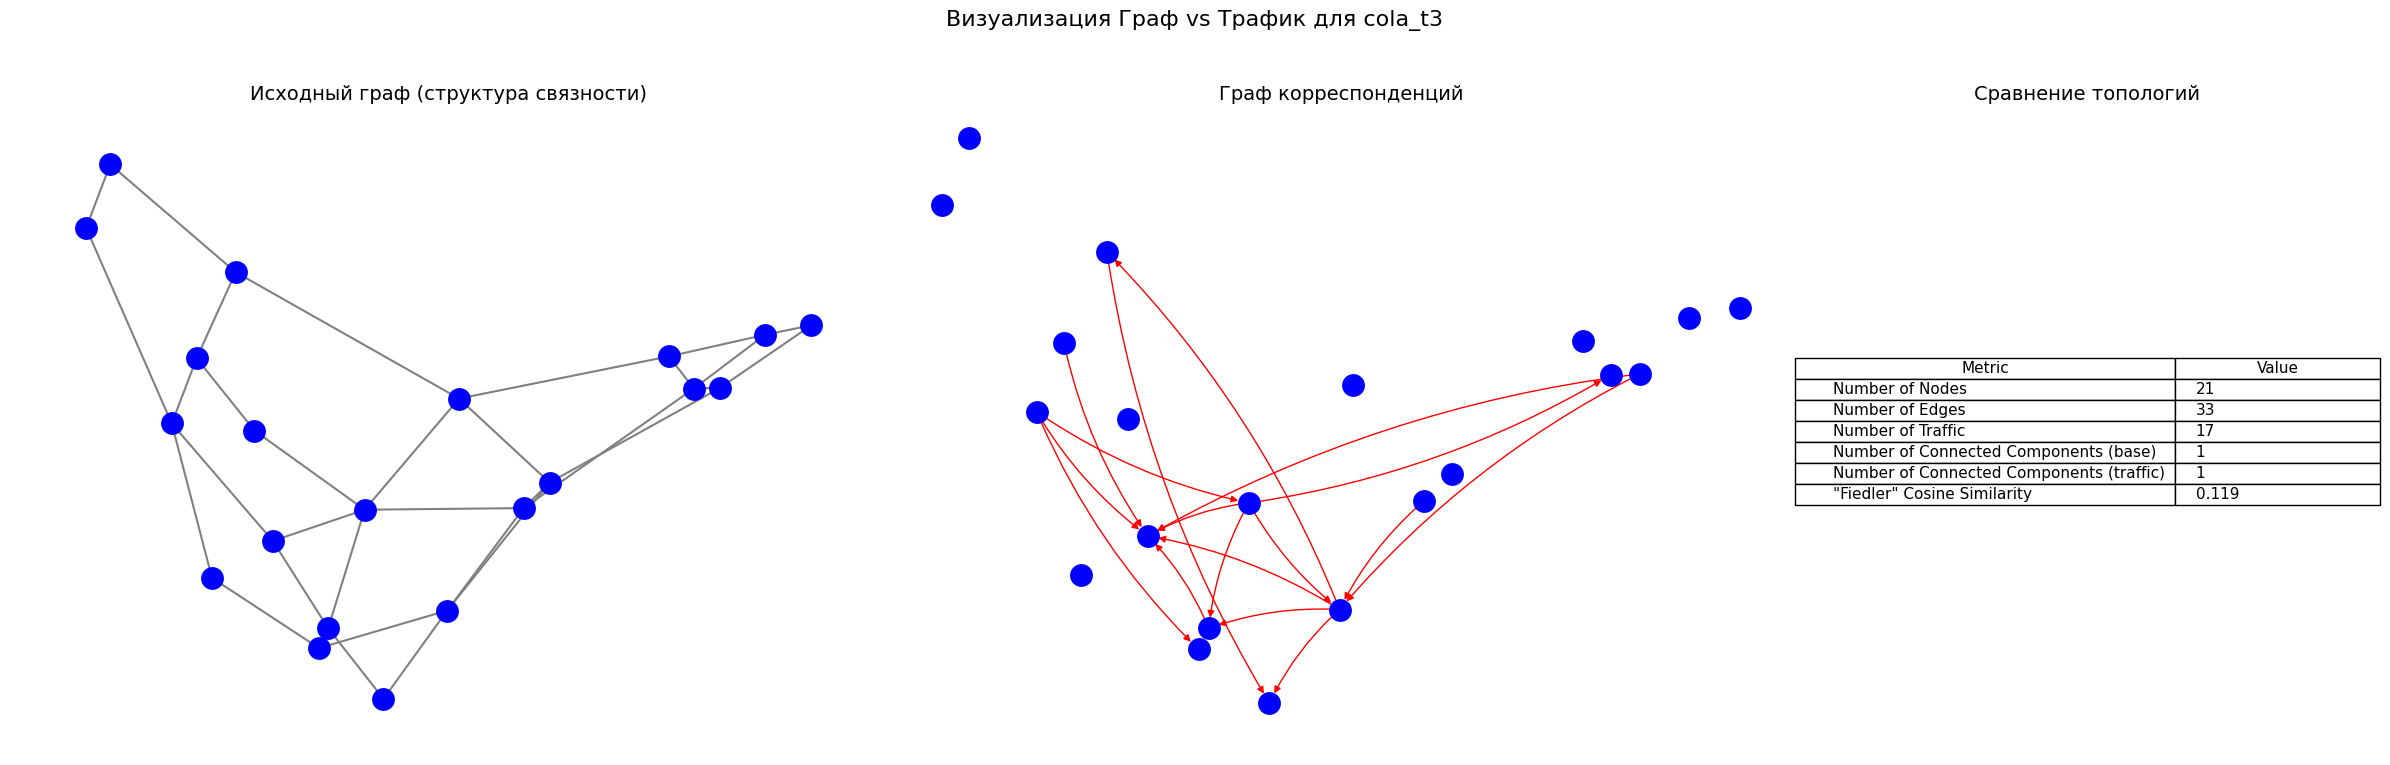

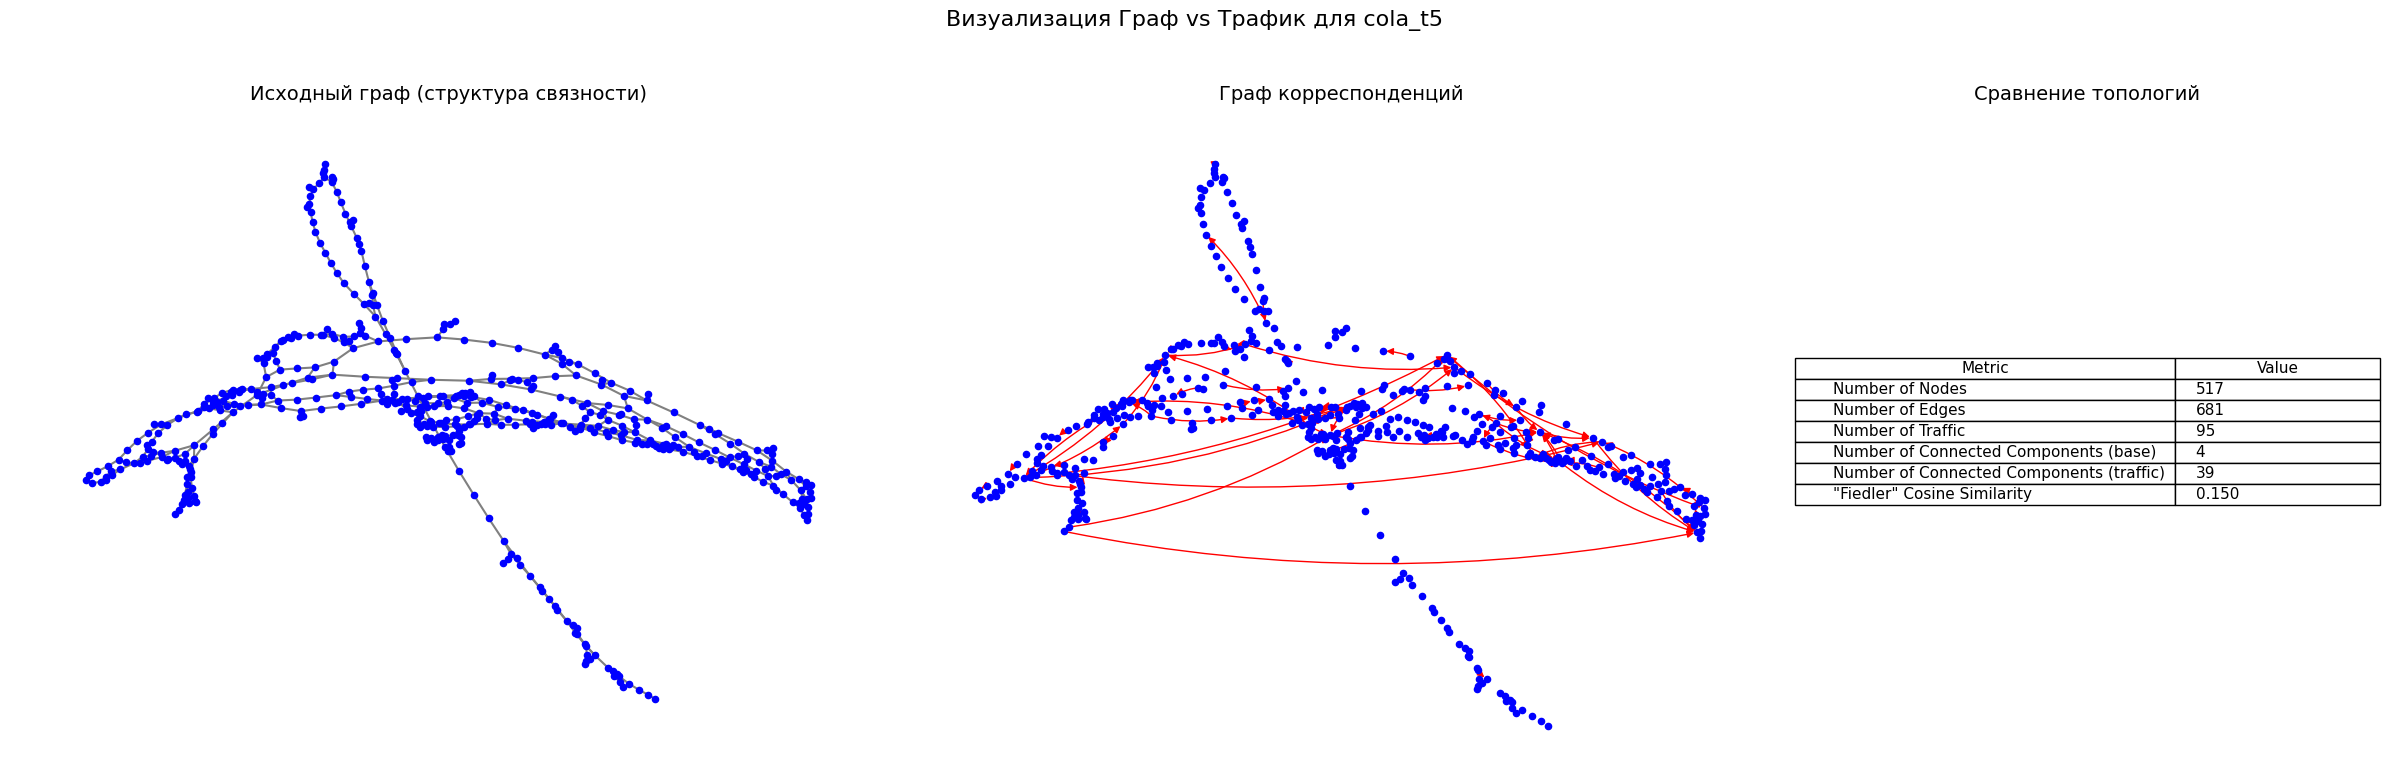

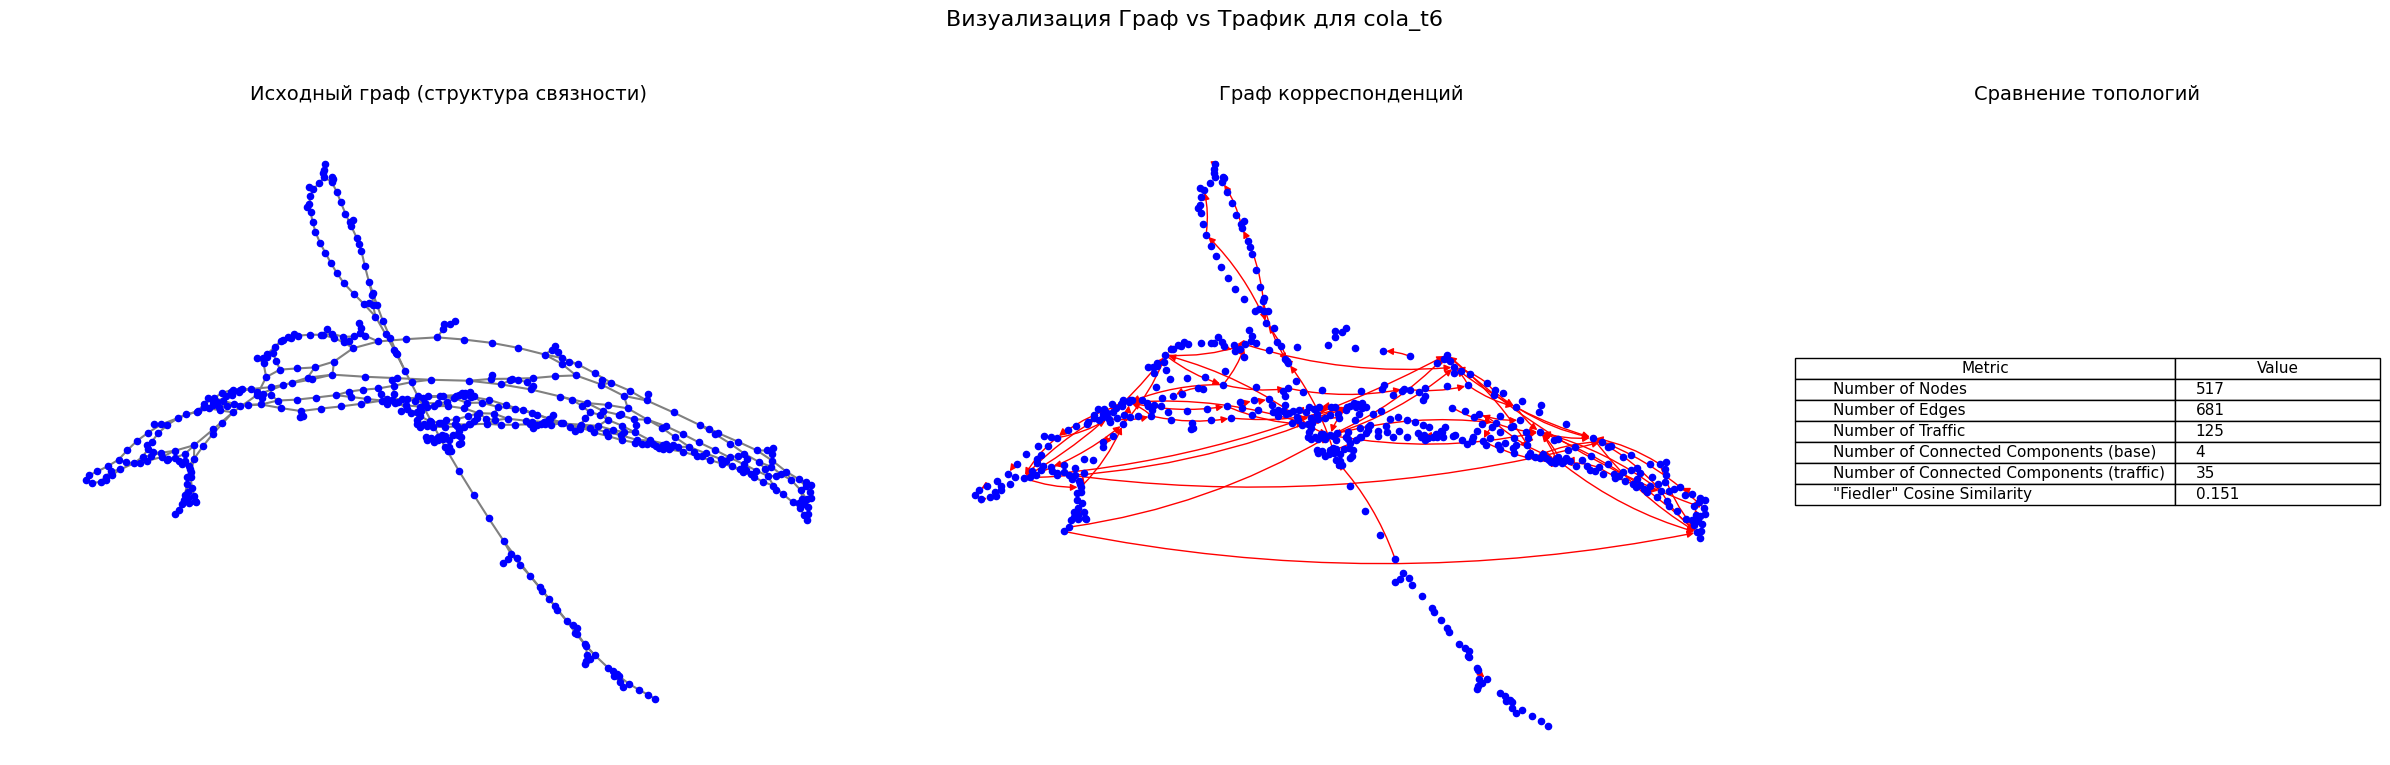

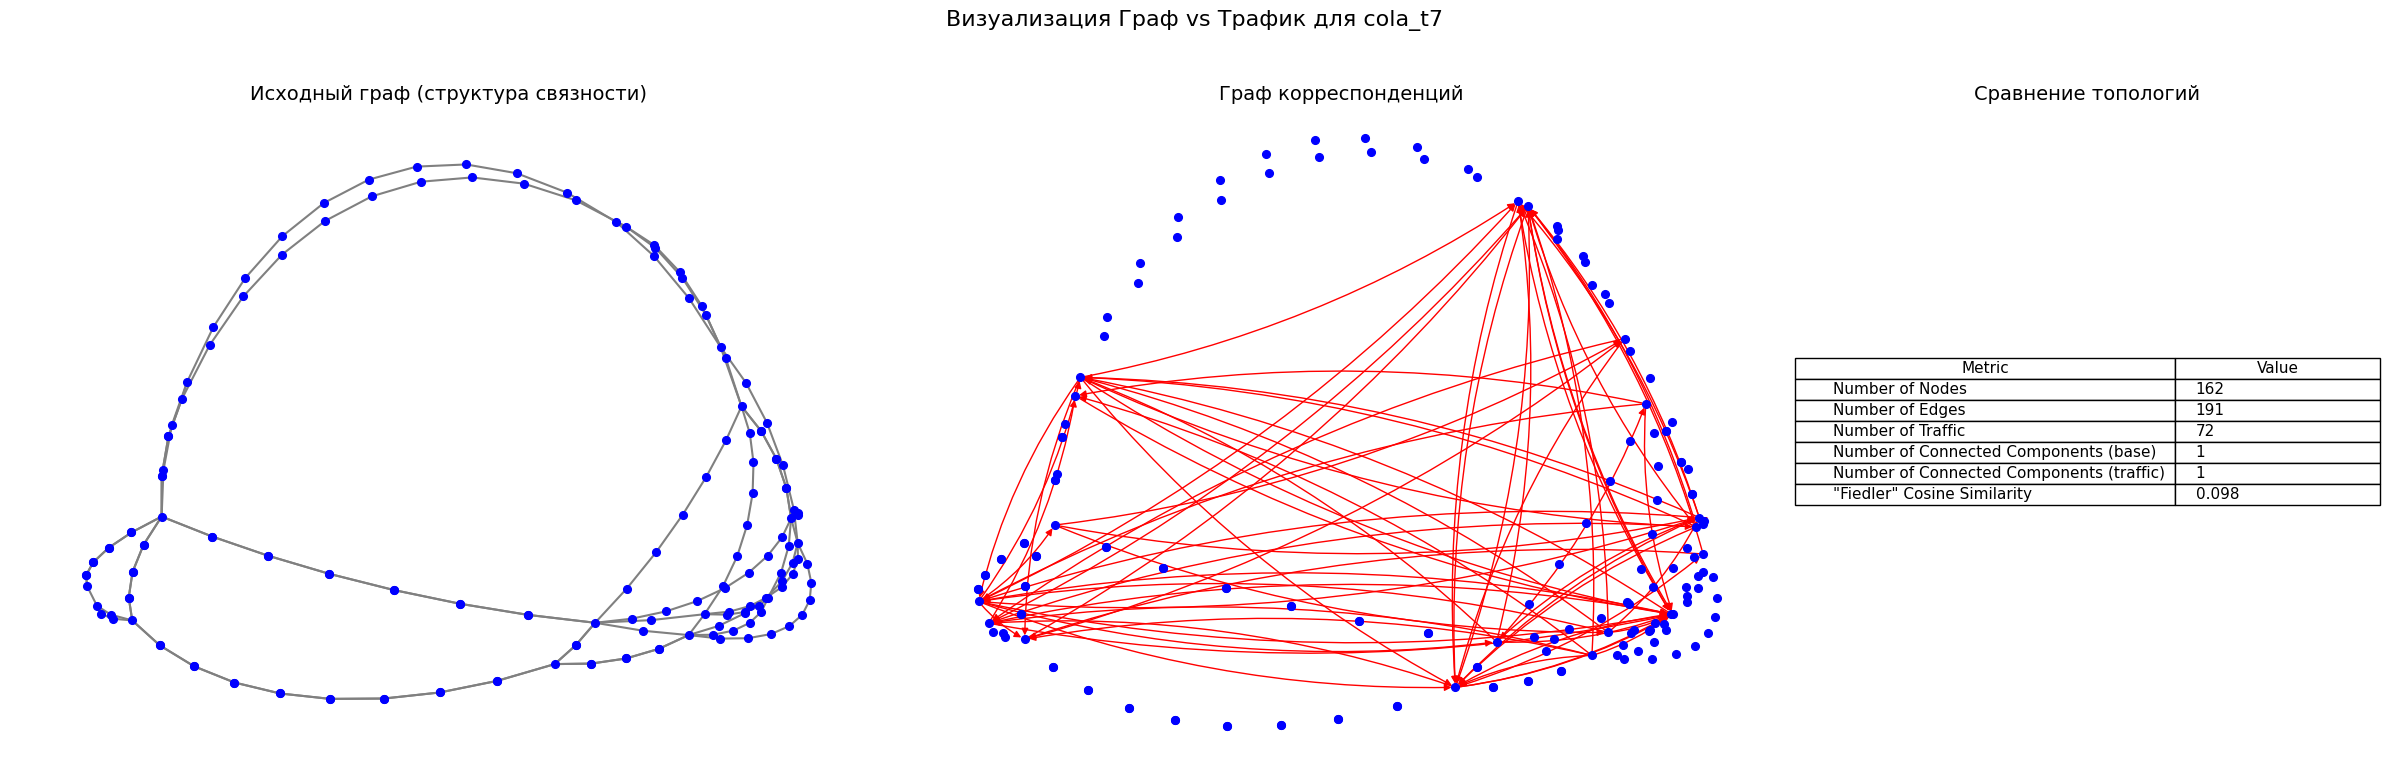

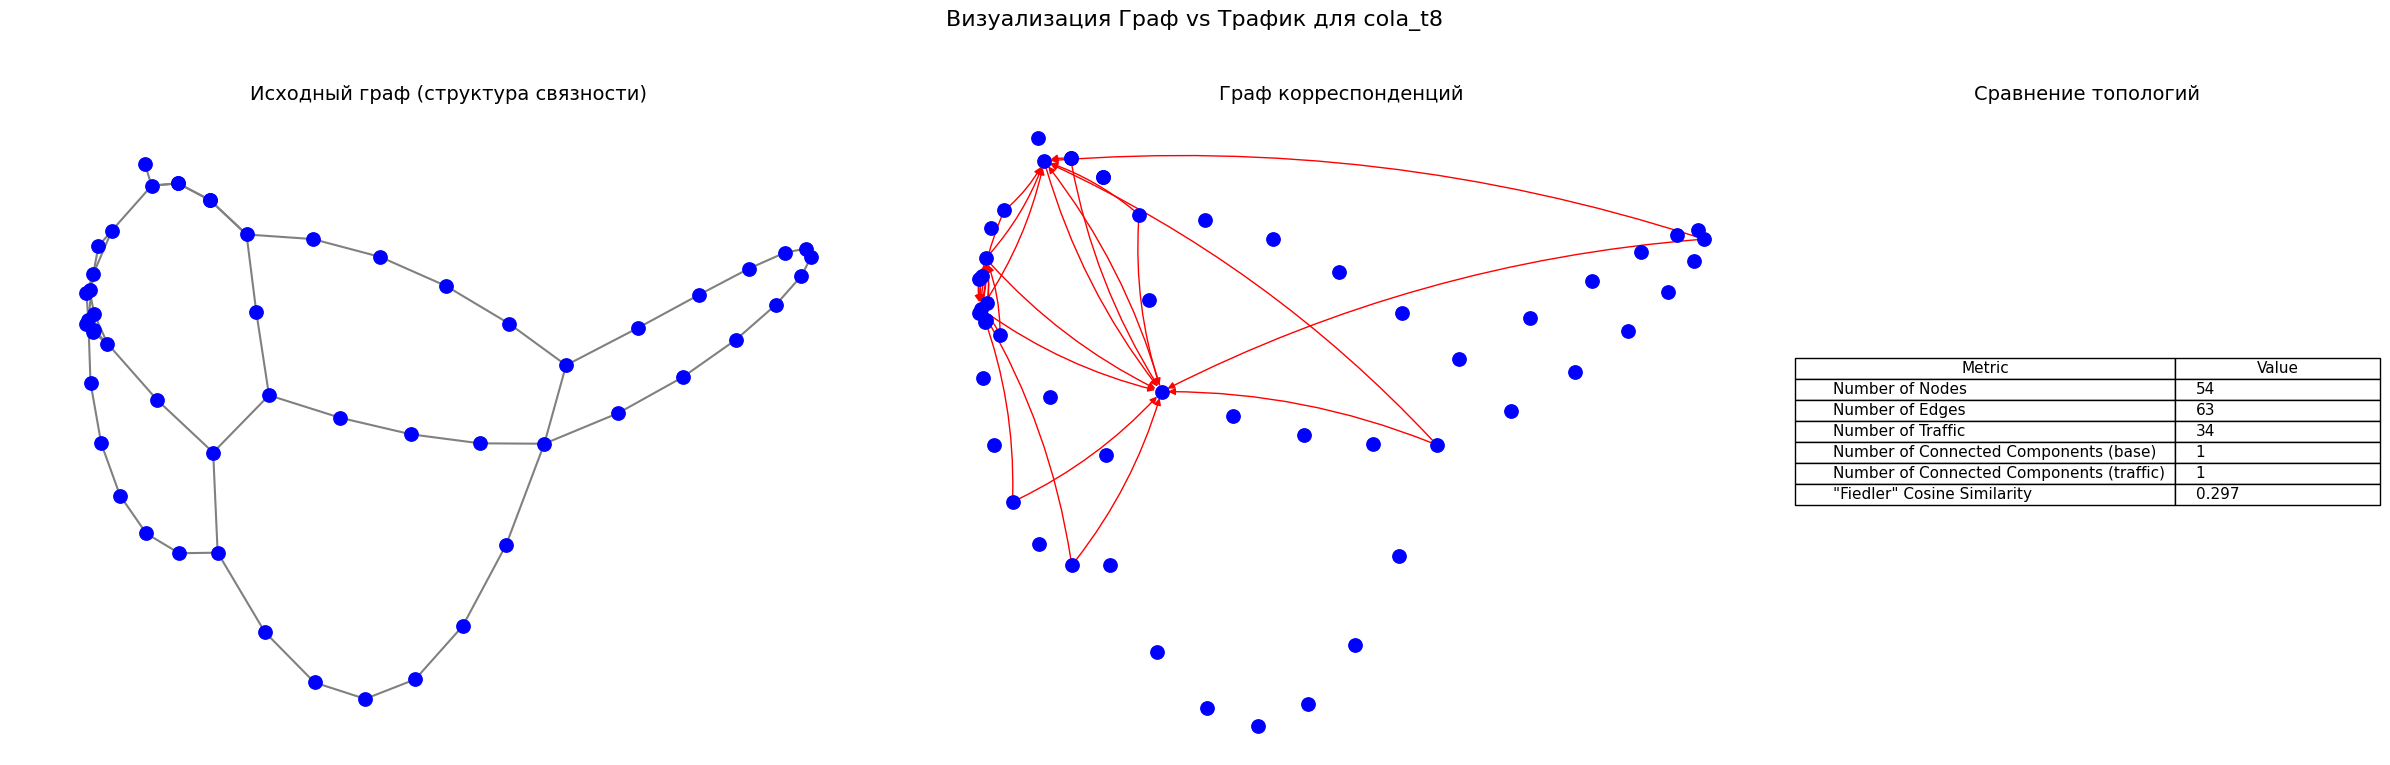

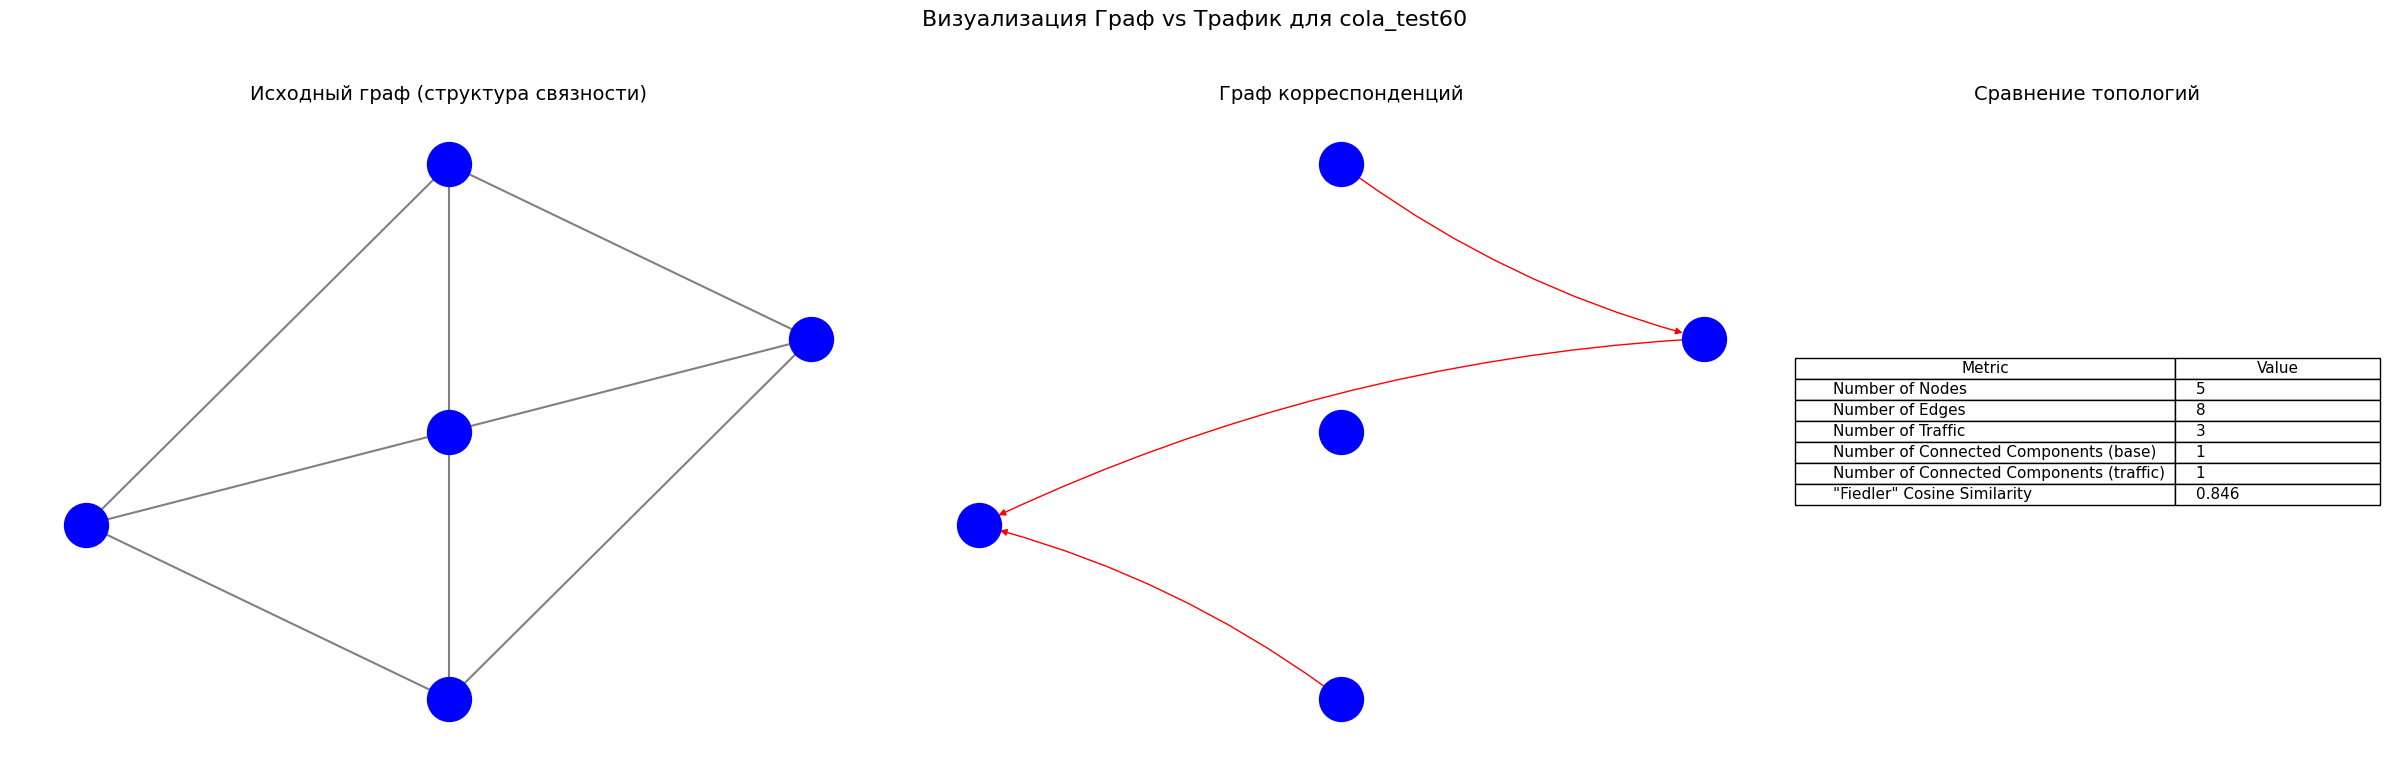

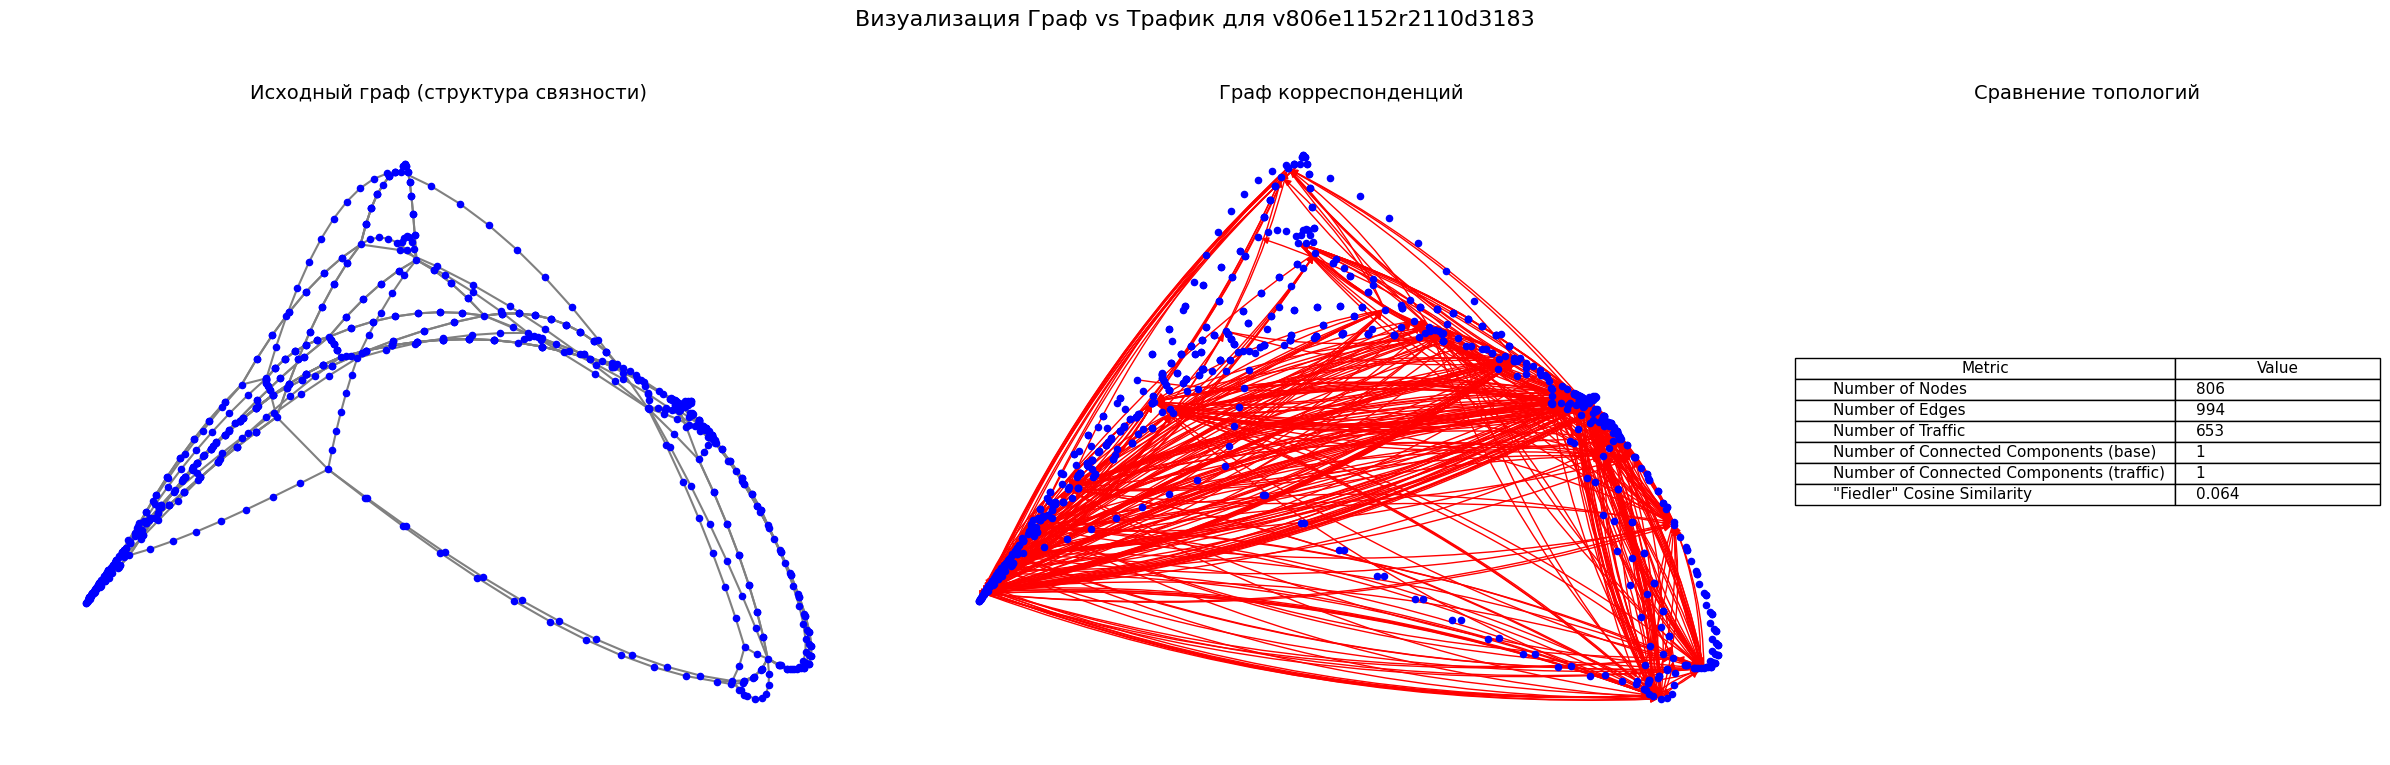

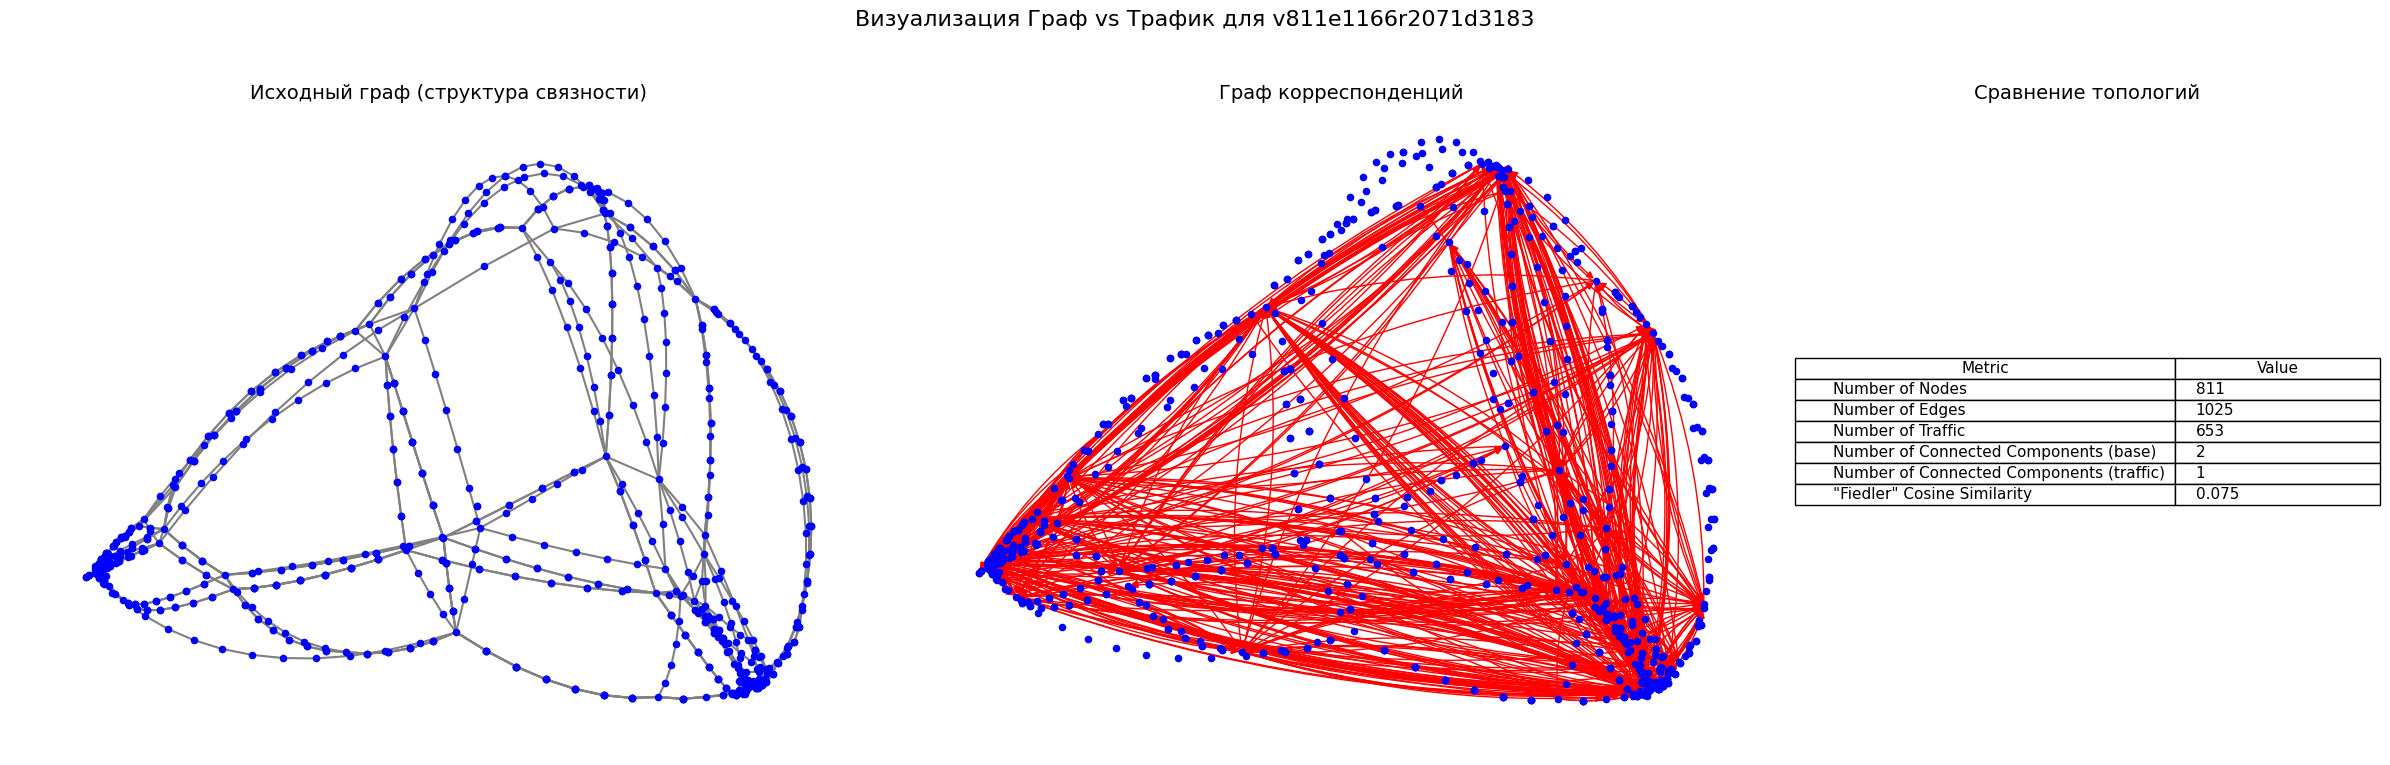

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

def calculate_spectral_similarity(g_base, g_traffic):
  base_components = list(nx.connected_components(g_base))
  lcc_base_nodes = max(base_components, key=len)
  g_base_lcc = g_base.subgraph(lcc_base_nodes)
  fiedler_base = nx.fiedler_vector(g_base_lcc, weight=None)

  g_traffic_sub = g_traffic.subgraph(lcc_base_nodes).copy()
  g_traffic_sub = g_traffic_sub.to_undirected()

  L_traffic = nx.laplacian_matrix(g_traffic_sub).toarray()
  eigenvalues, eigenvectors = np.linalg.eigh(L_traffic)

  tol = 1e-8
  first_nonzero_index = -1
  for i, val in enumerate(eigenvalues):
    if val > tol:
      first_nonzero_index = i
      break

  fiedler_traffic_generalized = eigenvectors[:, first_nonzero_index]


  cosine_distance = cosine(fiedler_base, fiedler_traffic_generalized)
  similarity = abs(1 - cosine_distance)

  return similarity


def graphs_visualisation(graphs_visualised):
  for name in sorted(graphs_visualised.keys(), key=lambda x: (x[:4], x[5:])):
    graph_vis = graphs_visualised[name]
    g_base = nx.from_numpy_array(graph_vis['adj_matrix_reduced'], create_using=nx.Graph)
    g_traffic = nx.from_numpy_array(graph_vis['traffic_matrix_reduced'], create_using=nx.DiGraph)

    num_nodes = g_base.number_of_nodes()
    num_edges = g_base.number_of_edges()
    num_traffics = g_traffic.number_of_edges()
    base_components_all = list(nx.connected_components(g_base))

    base_components_with_edges = sum(1 for comp in base_components_all if len(comp) > 1)
    traffic_undirected = g_traffic.to_undirected()
    all_traffic_components = nx.connected_components(traffic_undirected)
    traffic_components_with_edges = sum(1 for comp in all_traffic_components if len(comp) > 1)

    fiedler_sim = calculate_spectral_similarity(g_base, g_traffic)

    df_data = {
        'Metric': [
            'Number of Nodes',
            'Number of Edges',
            'Number of Traffic',
            'Number of Connected Components (base)',
            'Number of Connected Components (traffic)',
            '"Fiedler" Cosine Similarity'
        ],
        'Value':[
            num_nodes,
            num_edges,
            num_traffics,
            base_components_with_edges,
            traffic_components_with_edges,
            f'{fiedler_sim:.3f}' if not np.isnan(fiedler_sim) else 'NF'
        ]
    }
    df = pd.DataFrame(df_data)

    if len(base_components_all) > 2:
      pos = nx.spring_layout(g_base, seed=42, iterations=100)
    else:
      pos = nx.spectral_layout(g_base)

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [3, 3, 2]})
    plt.suptitle(f"Визуализация Граф vs Трафик для {name}", fontsize=16)


    ax1 = axes[0]
    nx.draw(g_base, pos, ax=ax1, with_labels=False, node_color='blue',
            node_size=max(5000/num_nodes, 20), edge_color='gray', width=1.5)
    ax1.set_title("Исходный граф (структура связности)", fontsize=14)

    ax2 = axes[1]
    nx.draw(g_traffic, pos, ax=ax2, with_labels=False, node_color='blue',
            node_size=max(5000/num_nodes, 20), edge_color='red', width=1.0,
            arrows=True, arrowsize=10, connectionstyle='arc3,rad=0.1')
    ax2.set_title("Граф корреспонденций", fontsize=14)

    ax3=axes[2]
    ax3.axis('off')
    ax3.set_title("Сравнение топологий", fontsize=14)

    table = ax3.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center',
        cellLoc='left',
        colWidths=[0.65,0.35]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.0, 1.2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


graphs_visualised = {}
for name, graph in Graphs.items():
  adj_matrix_reduced = (graph['adj_matrix'] > 0).astype(int)
  traffic_matrix_reduced = (graph['traffic_matrix'] > 0).astype(int)
  graphs_visualised[name] = {
      'adj_matrix_reduced' : adj_matrix_reduced,
      'traffic_matrix_reduced' : traffic_matrix_reduced
  }

graphs_visualisation(graphs_visualised)

In [ ]:
()